In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [1]:
!nvidia-smi
# DEBUG
import pynvml
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total / (1024**3)} Gb')
print(f'free     : {info.free / (1024**3)} Gb')
print(f'used     : {info.used / (1024**3)} Gb')

Tue Aug 25 03:28:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:1D:00.0  On |                  N/A |
| 26%   54C    P0    48W / 180W |    941MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [62]:
from datasets.common import read_calib_into_dict

_, _, calib_dict = read_calib_into_dict('datasets/')
R_02 = calib_dict['R_02'].reshape(3, 3)
t_02 = calib_dict['T_02'].reshape(3, 1)
R_03 = calib_dict['R_03'].reshape(3, 3)
t_03 = calib_dict['T_03'].reshape(3, 1)

T_02 = np.concatenate([R_02, t_02], axis=1)
T_30 = np.concatenate([R_03.T, -t_03], axis=1)
T_02 = np.concatenate([T_02, np.zeros((1, 4))], axis=0)
T_32 = np.dot(T_30, T_02)
print(T_32)

[[ 9.99556436e-01 -2.15336834e-02  2.05682018e-02  5.96187929e-02]
 [ 2.15658114e-02  9.99766559e-01 -1.34153856e-03  2.29718006e-04]
 [-2.05345103e-02  1.78451393e-03  9.99787519e-01  2.11314495e-03]]


In [3]:
%load_ext autoreload
%autoreload
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from datasets.kitti_raw_monosf import KITTI_Raw_KittiSplit_Train, KITTI_Raw_KittiSplit_Valid, CarlaDataset
from models.CNet import CNet
from augmentations import Augmentation_SceneFlow

from losses import _adaptive_disocc_detection
from losses import Loss_SceneFlow_SelfSup

args = {
    'batch_size' : 1,
    'num_workers' : 2,
    'epochs': 1, 
    'lr': 2e-4,
    'momentum': 0.9,
    'beta': 0.999,
    'weight_decay': 0.0,
    'train': True,
    'cuda': True,
    'debug': False,
    'evaluation': False,
    'finetuning': False,
}

data_root = '/external/datasets/kitti_data_jpg/'
# train_dataset = CarlaDataset({'baseline': 0.075}, data_root='/external/datasets/carla_stereo/Town01/')
train_dataset = KITTI_Raw_KittiSplit_Train(args={}, root=data_root, num_examples=100)
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True, pin_memory=True)
# val_dataset = KITTI_Raw_KittiSplit_Valid(args={}, root=data_root)
# val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=False, pin_memory=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'cam2cam' is not defined

input_k_l1: tensor([[721.5377,   0.0000, 623.4407],
        [  0.0000, 721.5377, 170.8540],
        [  0.0000,   0.0000,   1.0000]])
input_k_r1: tensor([[721.5377,   0.0000, 623.4407],
        [  0.0000, 721.5377, 170.8540],
        [  0.0000,   0.0000,   1.0000]])
input_k_l2: tensor([[721.5377,   0.0000, 623.4407],
        [  0.0000, 721.5377, 170.8540],
        [  0.0000,   0.0000,   1.0000]])
input_k_r2: tensor([[721.5377,   0.0000, 623.4407],
        [  0.0000, 721.5377, 170.8540],
        [  0.0000,   0.0000,   1.0000]])
index 0
basename 000000
datename 2011_09_26
input_size: tensor([ 375., 1242.])


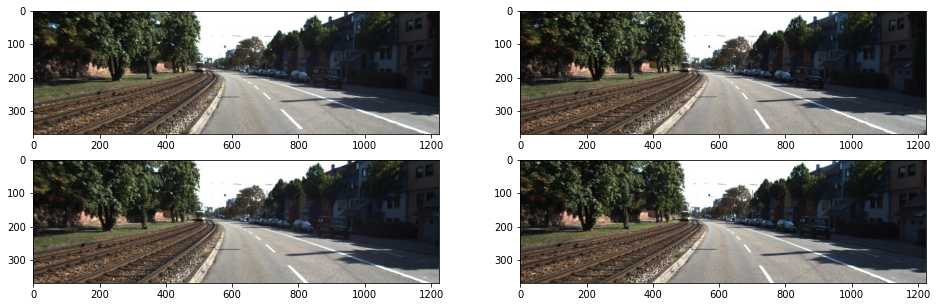

In [40]:
fig = plt.figure(figsize=(16, 16))
r, c = 6, 2
for i, (k, v) in enumerate(data.items()):
    if type(v) == float or type(v) == int or type(v) == str: 
        print(k, v)
        continue
    elif len(v.shape) == 3:
        fig.add_subplot(r, c, i+1)
        cmap = None
        img = v.permute(1, 2, 0)
        if img.shape[-1] == 1:
            img = img.squeeze()
            cmap = 'gray'
        plt.imshow(img, cmap=cmap)
    else:
        print(f"{k}: {v}")

In [2]:
augmentation = Augmentation_SceneFlow(args)
model = CNet(args)
model.train()

if args['cuda']:
    augmentation = augmentation.cuda()
    model = model.cuda()
    
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# optimizer = Adam(model.parameters(), lr=args['lr'], betas=[args['momentum'], args['beta']], weight_decay=args['weight_decay'])

start = time.time()
model.eval()
for i, data in enumerate(train_loader):
    
    input_keys = list(filter(lambda x: "input" in x, data.keys()))
    target_keys = list(filter(lambda x: "target" in x, data.keys()))
    tensor_keys = input_keys + target_keys

    # Possibly transfer to Cuda
    if args['cuda']:
        for key, value in data.items():
            if key in tensor_keys:
                data[key] = value.cuda(non_blocking=True)
    
    with torch.no_grad():
        data = augmentation(data)
        
    out = model(data)
        
    if i == 0:
        print((time.time() - start) / (i+1))
        break

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /pytorch/aten/src/THC/THCCachingHostAllocator.cpp:296

In [33]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
												   type(obj.data).__name__,
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

dump_tensors()

Parameter: GPU pinned 32 × 3 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 32 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 64 × 32 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 3 × 32 × 3 × 3
Parameter: GPU pinned 3
Parameter: GPU pinned 1 × 32 × 3 × 3
Parameter: GPU pinned 1
Parameter: GPU pinned 128 × 96 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 192 × 128 × 3 × 3
Parameter: GPU pinned 192
Parameter: GPU pinned 192 × 192 × 3 × 3
Parameter: GPU pinned 192
Parameter: GPU pinned 256 × 192 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 256 × 256 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 337 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 96 × 128 × 3 × 3
Parameter: GPU pinned 96
Parameter: GPU pinned 64 × 96 × 3 × 

/home/sniradi/envs/env_sf/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:100: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


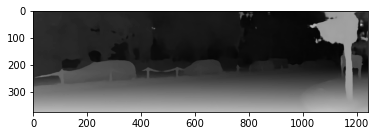

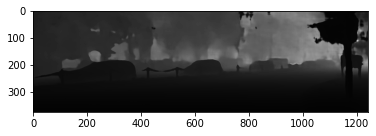

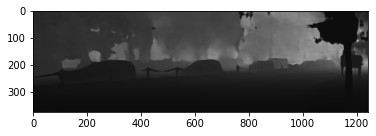

In [29]:
%autoreload
from losses import _disp2depth_kitti_K, _apply_disparity

disp = torch.tensor(plt.imread('../PSMNet/Test_disparity.png') / 255.)
plt.imshow(disp, cmap='gray')
plt.show()
depth_img = _disp2depth_kitti_K(disp, torch.tensor([721.5377])).squeeze()
depth_img_r = _apply_disparity(depth_img.unsqueeze(0).unsqueeze(0), disp.unsqueeze(0).unsqueeze(0))
plt.imshow(depth_img, cmap='gray')
plt.show()
plt.imshow(depth_img_r.squeeze(), cmap='gray')
plt.show()

In [9]:
print(torch.cuda.memory_cached() / torch.cuda.max_memory_cached())
print(torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated())

1.0
0.8481575964341026


In [5]:
%autoreload
start = time.time()
for i, data_dict in enumerate(train_loader):
    # Get input and target tensor keys
    input_keys = list(filter(lambda x: "input" in x, data_dict.keys()))
    target_keys = list(filter(lambda x: "target" in x, data_dict.keys()))
    tensor_keys = input_keys + target_keys

    # Possibly transfer to Cuda
    if args['cuda']:
        for key, value in data_dict.items():
            if key in tensor_keys:
                data_dict[key] = value.cuda(non_blocking=True)

    if augmentation is not None:
        with torch.no_grad():
            data_dict = augmentation(data_dict)
        
    x = model(data_dict)
    if i == 9:
        print(f"5 iterations took {time.time() - start}s")
        break

5 iterations took 4.380586862564087s


In [33]:
flow_s = torch.rand((1, 2, 3, 3))
flow_d = torch.rand((1, 2, 3, 3))
flow_cam = torch.rand((1, 2, 3, 3))
rigidity_mask = torch.randint(0, 2, (1, 1, 3, 3)).type_as(flow_s)

loss_static = torch.norm(flow_s * rigidity_mask, p=2)
loss_dynamic = torch.norm(flow_d * (1-rigidity_mask), p=2)
loss_static + loss_dynamic

torch.norm(flow_cam-flow_s, dim=1)

tensor([[[[0.0888, 0.8093, 0.5732],
          [0.3487, 0.5563, 0.5801],
          [0.8364, 0.3219, 0.6261]]]])
tensor([[[0.0888, 0.8093, 0.5732],
         [0.3487, 0.5563, 0.5801],
         [0.8364, 0.3219, 0.6261]]])


In [78]:
from utils.sceneflow_util import projectSceneFlow2Flow

# mask loss function

# optical flow losses
optical_flows = [projectSceneFlow2Flow(data_dict['input_k_l1'], sf, disp) for (sf, disp) in zip(x['flow_f'], x['disp_l1'])]

[torch.Size([1, 2, 256, 832]), torch.Size([1, 2, 128, 416]), torch.Size([1, 2, 64, 208]), torch.Size([1, 2, 32, 104]), torch.Size([1, 2, 16, 52])]


In [45]:
# create consistency loss functions
if data_dict:
    del data_dict
if x:
    del x
torch.cuda.empty_cache()

In [55]:
def train_one_epoch(model, dataloader, optimizer, augmentations):

  model.train()

  for i, data in enumerate(dataloader):
    continue

  return

In [58]:
for epoch in range(args['epochs']):
    loss_one_epoch = train_one_epoch(model, dataloader, optimizer, augmentations=augmentation)
    optimizer.zero_grad()
    loss_one_epoch.backward()
    

NameError: name 'optimizer' is not defined